In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
import arrayfire as af

import sys
sys.path.append('/solver/')
import solver

from solver.Mesh import *
from solver.SolverField import *
from solver.aux_solver import *
from solver.SbnSolver import *
from solver.DigitalTwin import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Simulation of 2 laser beams propagating inside an SBN crystal

In [6]:
### arrayfire configuration
print('Available Backends -> ', af.get_available_backends())

###set backend and device
af.set_backend('cuda')
af.set_device(0)

###print info
print(af.info_str())


Available Backends ->  ('cuda', 'opencl')
ArrayFire v3.6.1 (CUDA 64bit)
[0] : GeForce_GTX_1050 (Compute 6.1)



## 1.1. Some Auxiliary Functions

In [7]:
def phase_slip(x,y,A,w,x0,y0,vx,vy,width):
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**4) *np.exp((
                         ((x-x0)<0)*1j*np.pi))
    
    return new_field

def super_gauss(x,y,A,w,x0,y0,vx,vy,width,phase=0,x00=0,y00=0):
    aux = (((x - x0)*(x - x0)+ (y - y0)*(y - y0)) <= ( 0.8**2* (w*w)))
    new_field = A*np.exp(-(2*((x - x0)*(x - x0)+ (y - y0)*(y - y0)) / (w*w))**2)+1e-6
    new_field = new_field * (np.exp((1j*((vx*(x-x00))+(vy*(y-y00)))*aux)+1j*phase))
    return new_field

def whitenoise_2d_field_1(x,A):
    new_field = A*(0.5-np.random.rand(x.shape[0],x.shape[1]))*2         
    return new_field

def whitenoise_2d_field(x,A):
    new_field = np.random.normal(0,scale=A, size=(x.shape[0],x.shape[1]))#
    return new_field

def periodic_noise(y,A,k):
    new_field = A*np.sin(k*y)    
    return new_field

## 1.2. Configure Simulator and run

$$ i \partial_z E_{1} + \frac{1}{2} \nabla ^{2}_{\perp} E_{1} + c_{1} \Delta n_{max} \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_1+ \alpha E_1 = 0$$
$$ i \partial_z E_{2} + \frac{1}{2\gamma} \nabla ^{2}_{\perp} E_{2} + c_{2} \Delta n_{max} \gamma \frac{|E_1|^2 + |E_2|^2}{I_{sat}+|E_1|^2 + |E_2|^2} E_2 + \alpha E_2 = 0$$

$\Delta n_{max} = \frac{1}{2}n_{e}^{3}V/d$ with $d=5mm$ being the crystal width.  

In [46]:
# Simulation Box to match experiment
pixel_pitch = 1.25e-6
magnification = 200/60
x_camera = np.arange(0,4000)*pixel_pitch  #micrometers
y_camera = np.arange(0,3000)*pixel_pitch



## Crystal
lx=x_camera[-1]/ magnification
ly=y_camera[-1]/ magnification
lz=20e-3
n_passages = 1

## start digital twin model
c1 = 1 #rxx / r33
c2 = 40/250 # rxx / r33

V=400
Isat = 200 #mW/cm2

SBN_sim = DigitalTwin(lx=lx,ly=ly,lz=n_passages * lz,
                      V=V,c1=c1,c2=c2,Isat=Isat,
                      alpha=0)

phases = [0, np.pi/4,  2*np.pi/4,  3*np.pi/4, np.pi]

for phase_jump in phases:
    
    folder='E:\\TestData\\PhaseJump\\'
    saveDir = folder+str(np.round(phase_jump,4))
    SBN_sim.start_simulation_config(Nx=512,Ny=512,dz=0.05,save_dir=saveDir,stride=25)




    #######################################################################################
    #############State Initialization######################################################
    #######################################################################################

    If1=20

    factor_t = SBN_sim.factor_t

    SUPER_GAUSS_EXP = 2

    X, Y = SBN_sim.xx, SBN_sim.yy
    X -= X.max()/2
    Y -= Y.max()/2


    ########################################################
    #################   E1    ##############################
    ########################################################

    gaussian_beam = np.zeros(np.shape(X)) + 0j

    wx1 = 600e-6 * factor_t
    wy1 = 600e-6 * factor_t

    x_pos = 0
    y_pos = 0

    gaussian_beam += np.exp(-((2.0* (
                            (X - x_pos) ** 2.0 / (wx1**2.0)
                        +   (Y - y_pos) ** 2.0 / (wy1**2.0)
                            ))** SUPER_GAUSS_EXP)) + 0.00000000000000000001 + 0j


    gaussian_beam *= np.exp(1j*(X<0)*phase_jump)

    velocity = 0.0 * 2.0e4 *(200/60) / factor_t 
    #gaussian_beam*=np.exp(1j*velocity*X)

    print("sound velocity ->", np.sqrt(If1/Isat), "fluid velocity ->", velocity)

    gaussian_beam*=np.sqrt(If1)


    A_noise=0.05
    gaussian_beam = gaussian_beam*(1+whitenoise_2d_field(X,A_noise))
    SBN_sim.field1.add_field_numpy(gaussian_beam)


    ########################################################
    #################   E2    ##############################
    ########################################################


    If2=0

    gaussian_beam = np.zeros(np.shape(X)) + 0j
    SBN_sim.field2.add_field_numpy(gaussian_beam)

    SBN_sim.plot()

    simulate = True
    if simulate:
        SBN_sim.run()

delta_n -> 0.0001235560064
lx -> 302.4397292938621
ly -> 226.81088976051322
lz -> 29.185161053619055
healing length - > 7.012273216965854e-05
dx-> 0.5907025962770744 dy-> 0.4429900190635024
total steps to simulate -> 23
sound velocity -> 0.31622776601683794 fluid velocity -> 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Stride 0 of 23
Stride 1 of 23
Stride 2 of 23
Stride 3 of 23
Stride 4 of 23
Stride 5 of 23
Stride 6 of 23
Stride 7 of 23
Stride 8 of 23
Stride 9 of 23
Stride 10 of 23
Stride 11 of 23
Stride 12 of 23
Stride 13 of 23
Stride 14 of 23
Stride 15 of 23
Stride 16 of 23
Stride 17 of 23
Stride 18 of 23
Stride 19 of 23
Stride 20 of 23
Stride 21 of 23
Stride 22 of 23
dx-> 0.5907025962770744 dy-> 0.4429900190635024
total steps to simulate -> 23
sound velocity -> 0.31622776601683794 fluid velocity -> 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Stride 0 of 23
Stride 1 of 23
Stride 2 of 23
Stride 3 of 23
Stride 4 of 23
Stride 5 of 23
Stride 6 of 23
Stride 7 of 23
Stride 8 of 23
Stride 9 of 23
Stride 10 of 23
Stride 11 of 23
Stride 12 of 23
Stride 13 of 23
Stride 14 of 23
Stride 15 of 23
Stride 16 of 23
Stride 17 of 23
Stride 18 of 23
Stride 19 of 23
Stride 20 of 23
Stride 21 of 23
Stride 22 of 23
dx-> 0.5907025962770744 dy-> 0.4429900190635024
total steps to simulate -> 23
sound velocity -> 0.31622776601683794 fluid velocity -> 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Stride 0 of 23
Stride 1 of 23
Stride 2 of 23
Stride 3 of 23
Stride 4 of 23
Stride 5 of 23
Stride 6 of 23
Stride 7 of 23
Stride 8 of 23
Stride 9 of 23
Stride 10 of 23
Stride 11 of 23
Stride 12 of 23
Stride 13 of 23
Stride 14 of 23
Stride 15 of 23
Stride 16 of 23
Stride 17 of 23
Stride 18 of 23
Stride 19 of 23
Stride 20 of 23
Stride 21 of 23
Stride 22 of 23
dx-> 0.5907025962770744 dy-> 0.4429900190635024
total steps to simulate -> 23
sound velocity -> 0.31622776601683794 fluid velocity -> 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Stride 0 of 23
Stride 1 of 23
Stride 2 of 23
Stride 3 of 23
Stride 4 of 23
Stride 5 of 23
Stride 6 of 23
Stride 7 of 23
Stride 8 of 23
Stride 9 of 23
Stride 10 of 23
Stride 11 of 23
Stride 12 of 23
Stride 13 of 23
Stride 14 of 23
Stride 15 of 23
Stride 16 of 23
Stride 17 of 23
Stride 18 of 23
Stride 19 of 23
Stride 20 of 23
Stride 21 of 23
Stride 22 of 23
dx-> 0.5907025962770744 dy-> 0.4429900190635024
total steps to simulate -> 23
sound velocity -> 0.31622776601683794 fluid velocity -> 0.0


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Stride 0 of 23
Stride 1 of 23
Stride 2 of 23
Stride 3 of 23
Stride 4 of 23
Stride 5 of 23
Stride 6 of 23
Stride 7 of 23
Stride 8 of 23
Stride 9 of 23
Stride 10 of 23
Stride 11 of 23
Stride 12 of 23
Stride 13 of 23
Stride 14 of 23
Stride 15 of 23
Stride 16 of 23
Stride 17 of 23
Stride 18 of 23
Stride 19 of 23
Stride 20 of 23
Stride 21 of 23
Stride 22 of 23


## 2. Analysis

## 2.1 Load Data

In [55]:
from solver.af_loader import *

folder_phases = os.listdir(folder)
list_dir = [folder + f for f in os.listdir(folder)]
total_sim_states = []

for _saveDir in list_dir:
    sim_state = []
    sim_state2 = []

    zz= []
    n_state=5
    for passage in range(1, n_state):

        #########corrigir este loader

        print(_saveDir)
        my_mesh = mesh(_saveDir+"\\")
        stride_read = 1

        ntotalfiles = len([f for f in os.listdir(_saveDir+"\\gnlse_field\\") if f.endswith('.af')])
        index = int(ntotalfiles * passage/n_state)-1

        print(ntotalfiles,passage/n_passages, (index+1)/ntotalfiles)
        
        
        simulation_data,zs = load_data_folder(_saveDir+"\\gnlse_field\\", my_mesh,index=1,stride_read=stride_read, index_to_read = index)
        simulation_data2,zs = load_data_folder(_saveDir+"\\gnlse_field2\\",my_mesh, index=2, stride_read=stride_read, index_to_read = index)
        
        sim_state.append(np.transpose(simulation_data[0]))
        sim_state2.append(np.transpose(simulation_data2[0]))
        zz.append(zs[0])

        
    sim_state=np.array(sim_state)
    sim_state2=np.array(sim_state2)
    total_sim_states.append(sim_state)

total_sim_states = np.array(total_sim_states)


E:\TestData\PhaseJump\0
24 1.0 0.16666666666666666
E:\TestData\PhaseJump\0
24 2.0 0.375
E:\TestData\PhaseJump\0
24 3.0 0.5833333333333334
E:\TestData\PhaseJump\0
24 4.0 0.7916666666666666
E:\TestData\PhaseJump\0.7854
24 1.0 0.16666666666666666
E:\TestData\PhaseJump\0.7854
24 2.0 0.375
E:\TestData\PhaseJump\0.7854
24 3.0 0.5833333333333334
E:\TestData\PhaseJump\0.7854
24 4.0 0.7916666666666666
E:\TestData\PhaseJump\3.1416
24 1.0 0.16666666666666666
E:\TestData\PhaseJump\3.1416
24 2.0 0.375
E:\TestData\PhaseJump\3.1416
24 3.0 0.5833333333333334
E:\TestData\PhaseJump\3.1416
24 4.0 0.7916666666666666
E:\TestData\PhaseJump\1.5708
24 1.0 0.16666666666666666
E:\TestData\PhaseJump\1.5708
24 2.0 0.375
E:\TestData\PhaseJump\1.5708
24 3.0 0.5833333333333334
E:\TestData\PhaseJump\1.5708
24 4.0 0.7916666666666666
E:\TestData\PhaseJump\2.3562
24 1.0 0.16666666666666666
E:\TestData\PhaseJump\2.3562
24 2.0 0.375
E:\TestData\PhaseJump\2.3562
24 3.0 0.5833333333333334
E:\TestData\PhaseJump\2.3562
24 4.0

## 2.2 Plot States

In [56]:
from solver.analysis_auxiliary_functions import *
import cmocean

extent = [0,SBN_sim.lx*1e3,0,SBN_sim.ly*1e3]

fig,ax = plt.subplots(1,2,figsize=[10,4])

index1 = 0

fig.suptitle(r'$z='+str(np.round(2,2))+'$ cm')

ax[0].set_title(r'$|E_1|^2$' + ' Phase jump = ' + str(folder_phases[index1]))
ax[0].imshow(np.abs(total_sim_states[index1][-1])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')

index1=2

ax[1].set_title(r'$|E_1|^2$ ' + ' Phase jump = ' + str(folder_phases[index1]))
ax[1].imshow(np.abs(total_sim_states[index1][-1])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, '$y(mm)$')

In [57]:
%matplotlib widget
fig, ax = plt.subplots(1,1,figsize=[10,3])
x = np.linspace(0,lx,SBN_sim.Nx)*1e3
for ind, phase_jump in enumerate(folder_phases):
    state = (np.abs(total_sim_states[ind][-1])**2) - (np.abs(total_sim_states[0][0])**2)
    n0 = state.shape[0]/2
    wx=50 #npixels to mean
    mean_state = np.mean(state[int(n0-wx):int(n0+wx)], axis=0)
    plt.plot(x,mean_state, color=plt.cm.viridis(float(phase_jump)/np.pi), label = str(np.round(float(phase_jump)/np.pi,2)))

ax.set_xlabel(r'$x(mm)$')
ax.set_xlabel(r'$|E_1|^2$')
plt.legend()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## 3. Z Dynamics

In [71]:
fig,ax = plt.subplots(1,2)
index1=3
ax[0].set_title(r'$|E_1|^2$ ' + ' Phase jump = ' + str(folder_phases[index1]))
n0 = total_sim_states[index1][0].shape[0]/2
wy=50 
ax[0].imshow(np.abs(np.mean(total_sim_states[index1][:,int(n0-wy):int(n0+wy),:],axis=1))**2, aspect='auto', extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$z(cm)$')



ax[1].set_title(r'$|E_1|^2$ ' + ' Phase jump = ' + str(folder_phases[index1]))
n0 = total_sim_states[index1][0].shape[0]/2
wy=50 
ax[1].imshow(np.log10(np.abs(np.fft.fftshift(np.fft.fft(np.mean(total_sim_states[index1][:,int(n0-wy):int(n0+wy),:],axis=1),axis=1),axes=1))), 
             
             aspect='auto', extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[1].set_xlabel(r'$kx(mm)$')
ax[1].set_ylabel(r'$z(cm)$')



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, '$z(cm)$')

Text(0, 0.5, '$y(mm)$')

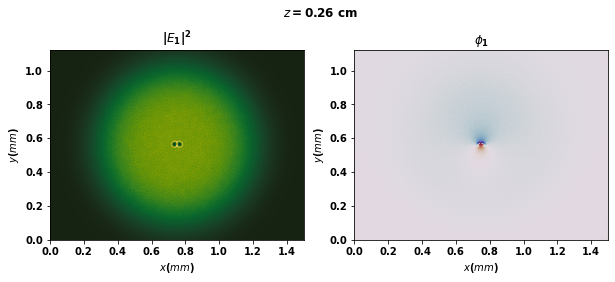

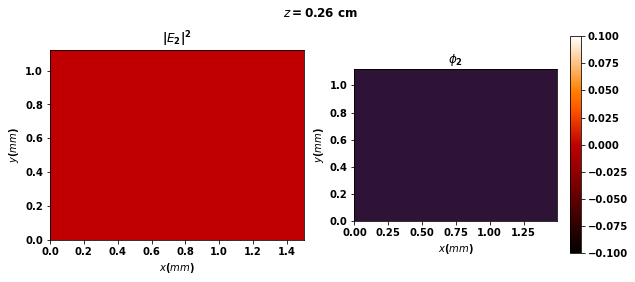

In [35]:
from solver.analysis_auxiliary_functions import *
import cmocean

index_plot = 1
z_value = zz[index_plot]/SBN_sim.factor_z*1e2
extent = [0,SBN_sim.lx*1e3,0,SBN_sim.ly*1e3]

fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_1|^2$')
ax[0].imshow(np.abs(sim_state[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=cmocean.cm.speed_r)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')

ax[1].set_title(r'$\phi_1$')
ax[1].imshow(np.angle(sim_state[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


fig,ax = plt.subplots(1,2,figsize=[10,4])

fig.suptitle(r'$z='+str(np.round(z_value,2))+'$ cm')
ax[0].set_title(r'$|E_2|^2$')
im = ax[0].imshow(np.abs(sim_state2[index_plot])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, extent = extent, origin='lower', cmap=plt.cm.gist_heat)
ax[0].set_xlabel(r'$x(mm)$')
ax[0].set_ylabel(r'$y(mm)$')
plt.colorbar(im)

ax[1].set_title(r'$\phi_2$')
ax[1].imshow(np.angle(sim_state2[index_plot]), aspect=SBN_sim.Nx / SBN_sim.Ny, extent=extent, origin='lower', cmap=plt.cm.twilight_shifted)
ax[1].set_xlabel(r'$x(mm)$')
ax[1].set_ylabel(r'$y(mm)$')


## 2.3 Plot multiple states with ROI

In [36]:

######
######just some auxiliary functions

from mpl_toolkits.axes_grid1 import make_axes_locatable


def get_ROI_CM(state, wx,wy, factor_t, dx,dy):
    ##wx, wy in micrometers around center of mass
    width_x, width_y = wx*factor_t/dx,wy*factor_t/dy

    center_of_mass_x, center_of_mass_y = get_center_of_mass_index(state)
    ix0, ix1 = int(center_of_mass_x - int(width_x)/2), int(center_of_mass_x + int(width_x)/2) 
    iy0, iy1 = int(center_of_mass_y - int(width_y)/2), int(center_of_mass_y + int(width_y)/2)

    return {'ix_min':ix0, 'ix_max':ix1, 'iy_min':iy0, 'iy_max': iy1}


def simple_ticks(ax, extent, axis='xy'):

    yticks = [extent[2],extent[2]+(extent[3]-extent[2]) /2, extent[3]]
    blankyticks = ['' for i in yticks]
    ytickslabels = [np.str(int(i)) for i in yticks]
    print(yticks,ytickslabels)
    xticks = [extent[0],extent[0]+(extent[1]-extent[0])/2, extent[1]]
    blankxticks = ['' for i in yticks]
    xtickslabels = [np.str(int(i)) for i in xticks]
    
    
    if axis == None:
        ax.set_yticks(yticks)
        ax.set_yticklabels(blankyticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(blankxticks)
        ax.set_xlabel(r'')
        ax.set_ylabel(r'')



    elif axis == 'x':
        ax.set_yticks(yticks)
        ax.set_yticklabels(blankyticks)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtickslabels)
        ax.set_xlabel(r'$x(\mu m)$')
        ax.set_ylabel(r'')


    elif axis == 'y':
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytickslabels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(blankxticks)
        ax.set_xlabel(r'')
        ax.set_ylabel(r'$y(\mu m)$')


    else:
        ax.set_yticks(yticks)
        ax.set_yticklabels(ytickslabels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtickslabels)
        ax.set_xlabel(r'$x(\mu m)$')
        ax.set_ylabel(r'$y(\mu m)$')




def plot_intensity(ax, state, dx, dy, ROI=None,
                   colornorm = None, cmap=plt.cm.gist_heat,
                   z_value = None, plot_label = None, 
                    ticks='xy',title='$|E|^2$',vmin=0,vmax=None):

    if ROI == None:
        ROI = {'ix_min':0,'ix_max':state.shape[0],'iy_min':0,'iy_max':state.shape[1]}
    
    _lx =(ROI['ix_max']-ROI['ix_min'])* dx
    _ly = (ROI['iy_max']-ROI['iy_min']) * dy
    print(_lx)
    
    extent = [-_lx/2,_lx/2,-_ly/2,_ly/2]
    
    

    ax.set_title(title)
    im = ax.imshow(np.abs(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']])**2, aspect=SBN_sim.Nx / SBN_sim.Ny, 
                   extent = extent, 
                   norm = colornorm, origin='lower', cmap=cmap,
                     vmin = vmin,vmax = vmax)

    simple_ticks(ax,extent, axis=ticks)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cb = plt.colorbar(im,cax=cax)
    cb.ax.set_title(r'$I_f (mW/cm^2)$',fontsize=10)


    lz=20e-3
    if z_value != None:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.95, 0.05, r'$z = '+str(z_value/lz)+'L_z$', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom',horizontalalignment='right', bbox=props)
    
    if plot_label != None:

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.05, 0.95, plot_label, transform=ax.transAxes, fontsize=12,color='w',
            verticalalignment='top',horizontalalignment='left', bbox=props)

    
def plot_phase(ax, state, dx, dy, ROI=None,
                   colornorm = None, cmap=plt.cm.twilight_shifted,
                   z_value = None, plot_label = None, 
                    ticks='xy',title='$\phi$'):

    if ROI == None:
        ROI = {'ix_min':0,'ix_max':state.shape[0],'iy_min':0,'iy_max':state.shape[1]}
        
    _xc = (ROI['ix_max']-ROI['ix_min'])/2 * dx
    _lx =(ROI['ix_max']-ROI['ix_min'])* dx

    _yc = (ROI['iy_max']-ROI['iy_min'])/2 * dy
    _ly = (ROI['iy_max']-ROI['iy_min']) * dy
    
    extent = [-_lx/2,_lx/2,-_ly/2,_ly/2]
    

    ax.set_title(title)
    
    phase_to_plot = np.angle(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']]+0.1)
    #phase_to_plot = np.angle(0.1+state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']]*np.exp(-1j*(np.angle(np.mean(state[ROI['iy_min']:ROI['iy_max'],ROI['ix_min']:ROI['ix_max']][1500-10:1500+10,1500-10:1500+10]))+np.pi/2)))
    phase_to_plot = (phase_to_plot-1*np.pi)%(2*np.pi) - np.pi

    
    im = ax.imshow(phase_to_plot, aspect=SBN_sim.Nx / SBN_sim.Ny, 
                   extent = extent, 
                   norm = colornorm, origin='lower', cmap=cmap,
                     vmin = -np.pi,vmax = np.pi,interpolation='none')
    ax.set_xlabel(r'$x(\mu m)$')
    ax.set_ylabel(r'$y(\mu m)$')

    simple_ticks(ax,extent, axis=ticks)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.15)

    cb = plt.colorbar(im,cax=cax)
    cb.ax.set_title(r'$\phi (rad)$',fontsize=10)


    lz=20e-3
    if z_value != None:
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
        ax.text(0.95, 0.05, r'$z = '+str(z_value/lz)+'L_z$', transform=ax.transAxes, fontsize=12,
            verticalalignment='bottom',horizontalalignment='right', bbox=props)
    
    if plot_label != None:

        props = dict(boxstyle='round', facecolor='wheat', alpha=0.0)
        ax.text(0.05, 0.95, plot_label, transform=ax.transAxes, fontsize=12,color='w',
            verticalalignment='top',horizontalalignment='left', bbox=props)


0
597.5068359375
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
5
597.5068359375
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']
[-199.884521484375, 0.0, 199.884521484375] ['-199', '0', '199']


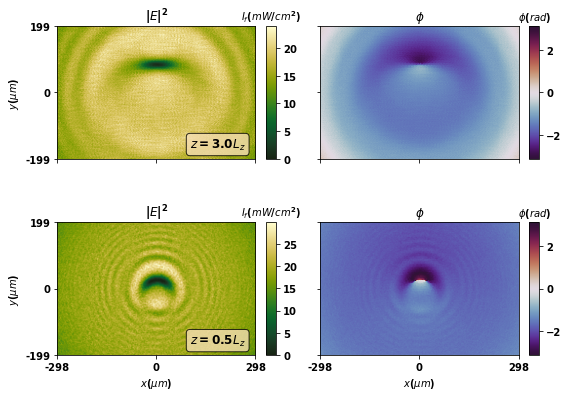

In [37]:
## Ex make a plot with 2x2 = 4 panels with amplitude and phase for two distinct z side by side

plots_x, plots_y = 2,2
sizex = 4
sizey = 3
fig,ax=plt.subplots(plots_x,plots_y,figsize=[sizex*plots_x,sizey*plots_y])

list_z_index = [0,5]
for i,iz in enumerate(list_z_index):
    print(iz)
    #########Compute Region of interest##################
    ROI_state = get_ROI_CM(sim_state[iz], wx=600,wy=400, 
            factor_t=SBN_sim.factor_t,dx=SBN_sim.dx*1e6,dy=SBN_sim.dy*1e6)

    if i!=plots_x-1:
        ticks_amplitude = 'y'
        ticks_phase = None
    else: 
        ticks_amplitude = 'xy'
        ticks_phase = 'x'


    plot_intensity(ax[i,0],sim_state[iz],
                SBN_sim.dx/factor_t*1e6,SBN_sim.dy/factor_t*1e6,
                ROI=ROI_state,
                cmap=cmocean.cm.speed_r,plot_label='',z_value = np.round(zz[iz]/SBN_sim.factor_z,2),
                ticks=ticks_amplitude)

    plot_phase(ax[i,1],sim_state[iz],
            SBN_sim.dx/factor_t*1e6,SBN_sim.dy/factor_t*1e6,
            ROI=ROI_state,
            cmap=plt.cm.twilight_shifted,
            ticks=ticks_phase)

fig.tight_layout()

## 3. Turbulence 

## 3.1. Kinetic Energy Power Laws

In [38]:
def get_kinetic_energy(field1, dx, dy, k_n=256):

    
    ux1 = np.abs(field1)*derivative_2_order_2d(np.unwrap(np.angle(field1),axis=1), dx, 1)    
    uy1 = np.abs(field1)*derivative_2_order_2d(np.unwrap(np.angle(field1),axis=0), dy, 0)  

    
    ux1[0,:] = 0
    ux1[-1,:] = 0
    ux1[:,0] = 0
    ux1[:,-1] = 0
    
    ux1[1,:] = 0
    ux1[-2,:] = 0
    ux1[:,1] = 0
    ux1[:,-2] = 0
    
    uy1[0,:] = 0
    uy1[-1,:] = 0
    uy1[:,0] = 0
    uy1[:,-1] = 0
    
    uy1[1,:] = 0
    uy1[-2,:] = 0
    uy1[:,1] = 0
    uy1[:,-2] = 0
    
    
    
    
    fx = np.fft.fftfreq(ux1.shape[1], dx) * 2 * np.pi
    fy = np.fft.fftfreq(ux1.shape[0], dy) * 2 * np.pi
    kx, ky = np.meshgrid(fx, fy)#, indexing='ij')
    #print(kx[:,0])
    
    print("fucntion\t", fx[1] - fx[0], "\t", fy[1] - fy[0])

    fux1 = np.fft.fft2(ux1,norm='ortho')
    fuy1 = np.fft.fft2(uy1,norm='ortho')
    
    
    fux1[0,0]=0
    fuy1[0,0]=0
    fux1[:,0]=0
    fux1[0,:]=0
    fuy1[:,0]=0
    fuy1[0,:]=0
    
    
    f_ucx1 = (kx * kx * fux1 + kx * ky * fuy1) / (kx * kx + ky * ky+1e-24)
    f_ucy1 = (ky * kx * fux1 + ky * ky * fuy1) / (kx * kx + ky * ky+1e-24)



    ucx1 = np.fft.ifft2(f_ucx1,norm='ortho')
    ucy1 = np.fft.ifft2(f_ucy1,norm='ortho')
    
    uix1 = ux1-ucx1
    uiy1 = uy1-ucy1
    
    f_uix1 = np.fft.fft2(uix1,norm='ortho')
    f_uiy1 = np.fft.fft2(uix1,norm='ortho')
    
    f_uix1[0,0]=0
    f_uiy1[0,0]=0
    f_uix1[:,0]=0
    f_uix1[0,:]=0
    f_uiy1[:,0]=0
    f_uiy1[0,:]=0
    
    f_uix1 = np.fft.fftshift(f_uix1)
    f_uiy1 = np.fft.fftshift(f_uiy1)
    f_uic1 = np.fft.fftshift(f_ucx1)
    f_uic1 = np.fft.fftshift(f_ucy1)
    kx = np.fft.fftshift(kx)
    ky = np.fft.fftshift(ky)

    kmax = np.sqrt(kx ** 2 + ky ** 2).max()
    kmin = np.sqrt(kx ** 2 + ky ** 2).min()
    

    R = np.sqrt(kx ** 2 + ky ** 2)
    _compressible = (f_ucx1 * np.conj(f_ucx1) + f_ucy1 * np.conj(f_ucy1))
    _imcompressible = (f_uix1 * np.conj(f_uix1) + f_uiy1 * np.conj(f_uiy1))

    r = np.linspace(0, kmax, k_n)
    
    def azimint_hist(data, npt, radius):
        histu = np.histogram(radius, npt)[0]
        histw = np.histogram(radius, npt, weights=data)[0]
        return histw / histu

    mean_eci = azimint_hist(_imcompressible, k_n, R)
    mean_ecc = azimint_hist(_compressible, k_n, R)
    
    return r, mean_eci, mean_ecc

In [ ]:
def compute_energy_spectra(v_field_fft, kx, ky, kz, bins):
    """
    Compute the energy spectra of the compressible and incompressible parts of a quantum fluid in Fourier space.

    :param v_field_fft: 3D array representing the Fourier transform of the velocity field.
    :param kx, ky, kz: Arrays representing the wavevector components in x, y, z directions.
    :param bins: Number of bins for radial integration.
    :return: A tuple (compressible_spectrum, incompressible_spectrum) representing the energy spectra.
    """
    # Compute the wavevector magnitude
    k_magnitude = np.sqrt(kx**2 + ky**2 + kz**2)

    # Compute the Fourier transform of the divergence and curl of the velocity field
    div_v_fft = 1j * (kx * v_field_fft[0] + ky * v_field_fft[1] + kz * v_field_fft[2])
    curl_v_fft = np.array([
        1j * (ky * v_field_fft[2] - kz * v_field_fft[1]),
        1j * (kz * v_field_fft[0] - kx * v_field_fft[2]),
        1j * (kx * v_field_fft[1] - ky * v_field_fft[0])
    ])

    # Avoid division by zero
    k_magnitude[k_magnitude == 0] = 1

    # Compute the compressible and incompressible parts in Fourier space
    v_compressible_fft = div_v_fft / k_magnitude**2
    v_incompressible_fft = curl_v_fft / k_magnitude**2

    # Compute energy densities
    compressible_energy_density = 0.5 * np.abs(v_compressible_fft)**2
    incompressible_energy_density = 0.5 * np.abs(v_incompressible_fft)**2

    # Bin the energies based on the magnitude of the wavevector
    bin_edges = np.linspace(0, k_magnitude.max(), bins + 1)
    compressible_spectrum, _ = np.histogram(k_magnitude, bins=bin_edges, weights=compressible_energy_density)
    incompressible_spectrum, _ = np.histogram(k_magnitude, bins=bin_edges, weights=incompressible_energy_density)

    return compressible_spectrum, incompressible_spectrum

# Example usage
# bins: Number of bins for the radial integration
compressible_spectrum, incompressible_spectrum = compute_energy_spectra(v_field_fft, kx, ky, kz, bins=100)

2.236743817172267e-05
fucntion	 21451.9688407165 	 35753.28140119417


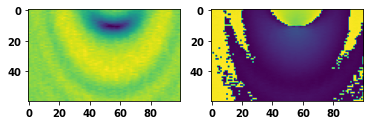

In [53]:
sx,sy = 1,1
scale_factor = 1

index_plot=8

If = 10
Isat = 200#820 
delta_n_max = 1.23*1e-4
ne=2.33
kf = 2*np.pi/(532e-9)
hl = 1/(kf*np.sqrt(ne*delta_n_max*If/Isat))
print(1/(kf*np.sqrt(ne*delta_n_max*If/Isat)))

#print(hl)

iy0,iy1=260,320
ix0,ix1=200,300

################
#para os vortex ficarem zero
st = np.abs(sim_state[index_plot][iy0:iy1,ix0:ix1][::sx,::sy])-np.min(np.abs(sim_state[index_plot][iy0:iy1,ix0:ix1][::sx,::sy]))+0.01
#st = ndimage.gaussian_filter(st,(3,3))
#st = (np.abs(st)-np.min(st))
st=st.astype('complex')
st *= np.exp( -1j * np.angle(sim_state[index_plot])[iy0:iy1,ix0:ix1][::sx,::sy])
#st = recon[i][iy0:iy1,ix0:ix1][::sx,::sy]
kr, eci,ec = get_kinetic_energy(scale_factor * st, SBN_sim.dx/SBN_sim.factor_t, SBN_sim.dx/SBN_sim.factor_t,k_n=int(50))#(200))
#kr, eci,ec = get_kinetic_energy_mean(scale_factor*recon[i][iy0:iy1,ix0:ix1][::sx,::sy], dx, dy,i_n=int(16))
fg,ax = plt.subplots(1,2)
kr*=1e-6*hl*1e6
ax[0].imshow(np.abs(st))
ax[1].imshow(np.angle(st))

eci=np.nan_to_num(np.abs(eci))
ec=np.nan_to_num(np.abs(eci))
# ecis.append(eci)#/np.max(eci))
# print('hl',hl*1e6)
# print(width_x, "\t", width_y, "\t", int(32/scale_factor), "\t", kr[2] - kr[1])

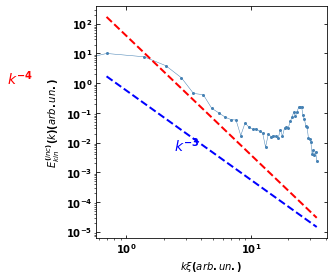

In [54]:
index_norm = np.argmin(np.abs(kr-1))

fig,ax = plt.subplots(1,1,figsize=[5,4])
ax.plot(np.abs(kr[:]), 10*np.abs(eci[:])/np.abs(eci[:][index_norm]),color='steelblue',
            label='$z_{eff} = '+str(np.round(i+1,2))+'L_z$',ls='-',lw=0.5,marker='o',ms=2)



index_low = np.argmin(np.abs(kr-1))

ax.plot(np.abs(kr[index_low:]),1.7e0*(np.abs(kr[index_low:])/np.abs(kr[index_low:][0]))**(-3),ls='--',lw=2,color='b')
ax.text(2.4,0.005,r'$k^{-3}$',color='b',fontsize=14)

# #ax.plot(np.abs(krs[i][:]),60*(np.abs(krs[i][:])/np.abs(krs[i][:][1]))**(-5.0/3.0),ls='--',color='g')


ax.plot(np.abs(kr[index_low:]),1.7e2*(np.abs(kr[index_low:])/np.abs(kr[:index_low+1][1]))**(-4),ls='--',lw=2,color='r')
ax.text(0.11,0.9,r'$k^{-4}$',color='r',fontsize=14)
# #If = 18
# #Isat = 400 
#delta_n_max = 1.18*1e-4
#kf = 2*np.pi / (532e-3)
#hl = 1/(kf*np.sqrt(ne*delta_n_max*If/Isat))
#ax.axvline(1,ls='--',color='k')
ax.set_xscale('log')
ax.set_yscale('log')
#plt.axvline(x=1,ls='--',color='k',lw=0.5)
#plt.axvline(x=3,ls='--',color='k',lw=0.5)
#plt.axhline(y=1)
ax.set_ylabel(r'$E^{(inc)}_{kin} (k) (arb.un.)$')
ax.set_xlabel(r'$k \xi (arb.un.)$')
#ax.set_ylim((0.0024,3000))

#ax.set_ylim((1e-4,1e4))
#xmx = 7
#ax.set_xlim((0.08,xmx))
#ax.set_xticks([0.05,1.0,xmx])
#ax.set_xticklabels([0.05,1,xmx])
#ax.legend(loc='lower left',bbox_to_anchor=(0.05, 0.05))
#fig.tight_layout()

ax.tick_params(axis='both',direction="in",top=True,right=True)

fig.tight_layout()